In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Read in pySB99 files and combine them into a hdf5 file of the proper format

In order for Enzo to read the tables properly, we need several arrays where the first index is population metallicity, second index is population age, and third index is the thing we want -- wind mass, wind metal mass, wind+photon momentum.

First step is to run Starburst99 for a number of different metallicities. This notebook is set up assuming this has been done, and that the resulting Starburst99 tables are located in the directories listed in 'modeldirs' below. I used pySB99, the python wrapper for Starburst99, to generate the table in this notebook. At the time of table generation, pySB99 could be found at https://github.com/CalumHawcroft/Starburst.

In [2]:
population_age = np.arange(0.00e6, 50e6, 0.1e6) # Make sure this lines up with how SB99 was run
initial_metal_fraction = np.array([0.0, 0.0004, 0.002, 0.006, 0.014, 0.02])  # Make sure this lines up with the different-metallicity SB99 runs. Note that these are actual metal fractions so 0.02 is solar.
print(len(population_age), len(initial_metal_fraction))

500 6


Read in all pySB models and smooth them in time before combining into one big table. The original models have some odd spikes that might cause issues with interpolation.

In [3]:
filedir = '/Users/clochhaas/Starburst/'
modeldirs = ['pySB_Z0', 'pySB_Z0004', 'pySB_Z002', 'pySB_Z006', 'pySB_Z014', 'pySB_Z02']

In [4]:
wind_mass = np.loadtxt(filedir + modeldirs[-1] + '/windmass.txt') # Wind mass is in units of Msun/yr
wind_metals = np.loadtxt(filedir + modeldirs[-1] + '/windmetals.txt') # Wind metal mass is in units of Msun/yr
wind_momentum = 10**np.loadtxt(filedir + modeldirs[-1] + '/windmom.txt') # Wind momentum is actually pdot, in units of dynes (g cm/s^2)
Lbol = 10**np.loadtxt(filedir + modeldirs[-1] + '/bololum.txt') # Bolometric luminosity is in units of ergs/s

In [5]:
# Smooth in a moving window
window_size = 10
window = np.ones(window_size) / window_size
light_c = 2.998e10
wind_mass_smoothed = np.convolve(np.pad(wind_mass, window_size//2, mode='edge'), window, mode='valid')[:-1]
wind_metals_smoothed = np.convolve(np.pad(wind_metals, window_size//2, mode='edge'), window, mode='valid')[:-1]
wind_mom_smoothed = np.convolve(np.pad(wind_momentum, window_size//2, mode='edge'), window, mode='valid')[:-1]
Lbol_smoothed = np.convolve(np.pad(Lbol, window_size//2, mode='edge'), window, mode='valid')[:-1]

The S99 models were run with a cluster mass of $10^6 M_\odot$ so all the following plots are normalized to 1 Msun.

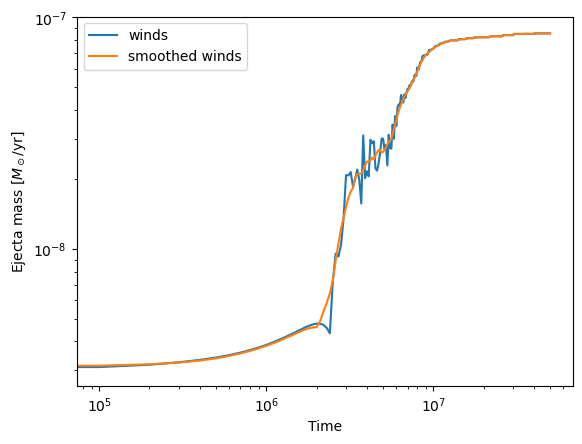

In [7]:
plt.close()
plt.plot(population_age, wind_mass/1e6, label='winds')
plt.plot(population_age, wind_mass_smoothed/1e6, label='smoothed winds')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel(r'Ejecta mass [$M_\odot$/yr]')
plt.legend()
plt.show()

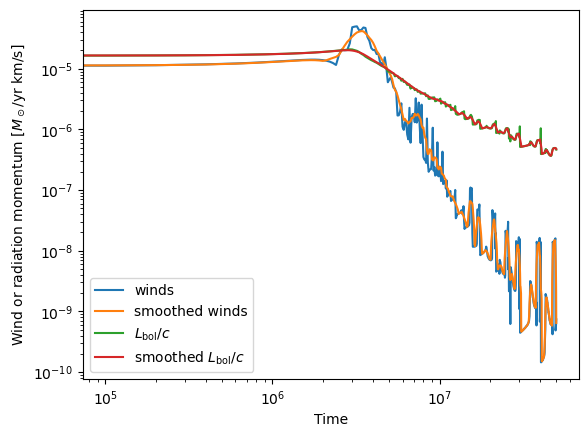

In [8]:
light_c = 2.998e10
SolarMass = 1.989e33
yr_s = 3.155e7
plt.close()
plt.plot(population_age, wind_momentum/1e6/(SolarMass/yr_s*1e5), label='winds')
plt.plot(population_age, wind_mom_smoothed/1e6/(SolarMass/yr_s*1e5), label='smoothed winds')
plt.plot(population_age, Lbol/1e6/light_c/(SolarMass/yr_s*1e5), label=r'$L_\mathrm{bol}/c$')
plt.plot(population_age, Lbol_smoothed/1e6/light_c/(SolarMass/yr_s*1e5), label=r'smoothed $L_\mathrm{bol}/c$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel(r'Wind or radiation momentum [$M_\odot$/yr km/s]')
plt.legend()
plt.show()

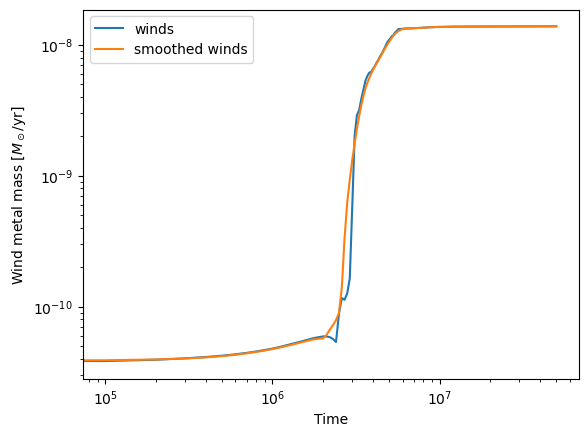

In [9]:
plt.close()
plt.plot(population_age, wind_metals/1e6, label='winds')
plt.plot(population_age, wind_metals_smoothed/1e6, label='smoothed winds')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel(r'Wind metal mass [$M_\odot$/yr]')
plt.legend()
plt.show()

Now that we've verified what they look like after smoothing, combine all the SB99 tables into arrays of the correct shape (first index metallicity, second index time).

In [ ]:
wind_mass = []
wind_metals = []
wind_mom = []
window_size = 10
window = np.ones(window_size) / window_size
light_c = 2.998e10
SolarMass = 1.989e33
yr_s = 3.155e7
for Z in modeldirs:
    mass = np.loadtxt(filedir + Z + '/windmass.txt') # Wind mass is in units of Msun/yr
    metals = np.loadtxt(filedir + Z + '/windmetals.txt') # Wind metal mass is in units of Msun/yr
    momentum = 10**np.loadtxt(filedir + Z + '/windmom.txt') # Wind momentum is actually pdot, in units of dynes (g cm/s^2)
    Lbol = 10**np.loadtxt(filedir + Z + '/bololum.txt') # Bolometric luminosity is in units of ergs/s
    mass_smoothed = np.convolve(np.pad(mass, window_size//2, mode='edge'), window, mode='valid')[:-1]
    metals_smoothed = np.convolve(np.pad(metals, window_size//2, mode='edge'), window, mode='valid')[:-1]
    mom_smoothed = np.convolve(np.pad(momentum, window_size//2, mode='edge'), window, mode='valid')[:-1]
    Lbol_smoothed = np.convolve(np.pad(Lbol, window_size//2, mode='edge'), window, mode='valid')[:-1]
    wind_mass.append(mass_smoothed/1e6) # Normalize by star cluster size 10^6 Msun (change this if SB99 tables were run with a different mass)
    wind_metals.append(metals_smoothed/1e6) # Normalize by star cluster size 10^6 Msun
    wind_mom.append((mom_smoothed/1e6 + Lbol_smoothed/light_c/1e6)/(SolarMass/yr_s*1e5)) # Convert pdot to Msun/yr*km/s and normalize by star cluster size
wind_mass = np.array(wind_mass)
wind_metals = np.array(wind_metals)
wind_mom = np.array(wind_mom)

In [11]:
np.shape(wind_mass)

(6, 500)

Save the arrays into an hdf5 file with the right group and dataset structure that Enzo expects.

In [26]:
f = h5py.File('preSN_feedback_SB99.hdf5', 'a')
grp = f.create_group("indexer")
dset_Z = grp.create_dataset("initial_metal_fraction", data=initial_metal_fraction)
dset_age = grp.create_dataset("population_age", data=population_age)
dset_age.attrs['time_unit'] = 'yr'
f.close()

In [27]:
f = h5py.File('preSN_feedback_SB99.hdf5', 'a')
grp = f.create_group("SB99_models")
dset_mass = grp.create_dataset("wind_mass_rate", data=wind_mass)
dset_metals = grp.create_dataset("wind_metal_mass_rate", data=wind_metals)
dset_mom = grp.create_dataset("wind_and_Lbol_momentum", data=wind_mom)
dset_mass.attrs['unit'] = 'Msun/yr'
dset_metals.attrs['unit'] = 'Msun/yr'
dset_mom.attrs['unit'] = 'Msun/yr*km/s'
f.close()